# Visualization of training results

This notebook uses the saved training data and shows the results visually for further analysis. I tried to follow the guidelines from [this](http://rll.berkeley.edu/deeprlcourse/docs/plotting_handout.pdf) handout of the cs294 DeepRL course from UCBerkeley, in which it gives various suggestions for storing training data, making visualizations, etc..

Following these suggestions, the method used for making visualizations of the training results is as follows:

* Saving training results into tensorboard runs and then export them to .csv files for later plotting.
* Loading the results from the saved .csv files (logger.py) after all training runs have been made (various runs with same hyperparameters, and also with two different seeds)
* Visualizing the results (this notebook) using std plots of the various saved statistics.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import logger
import plotter

from IPython.core.debugger import set_trace

%matplotlib inline

## Plot single training runs

This part deals with the visualization of single runs (for testing purposes). There is going to be at least one training
session *tensorboard* file in the repo (and perhaps no more, as each weights quite a little).

* First, let's define some helper functions to visualize single runs:

In [4]:
# folder where all runs are located (exported csv files from tensorboard)
BASE_FOLDER = os.path.join( os.getcwd(), 'results/csv' )

# a helper to plot a training series
def plotSeries( series, 
                color = 'r', 
                title = '', 
                linestyle = '-', 
                fig = None, 
                axes = None, 
                showRequirement = True ) :
    # iteration indices (recall, smoothed start at step 100)
    _steps = series[0]
    _data = series[1]
    
    if fig is None or axes is None :
        fig, axes = plt.subplots()
    
    axes.grid( True )
    axes.plot( _steps, _data, color = color, linestyle = linestyle )
    axes.set_title( title )
    
    # if scores plot, then plot the requirement
    if showRequirement :
        axes.axhline( 0.5, linestyle = '--' )
    
    return fig, axes

# a helper to plot the results of a run
def plotSingleRun( sessionId, 
                   title = 'Scores during training', 
                   hideMain = False,
                   showAll = True, 
                   fig = None, 
                   axes = None, 
                   useRandomColor = False,
                   showRequirement = True ) :
    # path to .csv file (from sessionId)
    _filepathAll = os.path.join( BASE_FOLDER, 'run_' + sessionId + '_tensorboard_summary_score.csv' )
    _filepathAvg = os.path.join( BASE_FOLDER, 'run_' + sessionId + '_tensorboard_summary_avg_score.csv'  )
    
    # load all training results
    _seriesAll = logger.loadTrainingResultsCsv( _filepathAll )
    _seriesAvg = logger.loadTrainingResultsCsv( _filepathAvg )
    
    if fig is None or axes is None :
        fig, axes = plt.subplots()
    
    # plot all results available
    if showAll :
        fig, axes = plotSeries( _seriesAll, 
                                color = 'b' if not useRandomColor else np.random.rand( 3, ), 
                                title = title,
                                fig = fig,
                                axes = axes,
                                showRequirement = showRequirement )
    if not hideMain :
        fig, axes = plotSeries( _seriesAvg, 
                                color = 'r' if not useRandomColor else np.random.rand( 3, ), 
                                title = title,
                                fig = fig,
                                axes = axes,
                                linestyle = '-',
                                showRequirement = showRequirement )
    
    axes.set_xlabel( 'Episodes' )
    axes.set_ylabel( 'Score' )
    
    return fig, axes

* Plot some of the results of the *submission* training session


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9d29c27f98>)

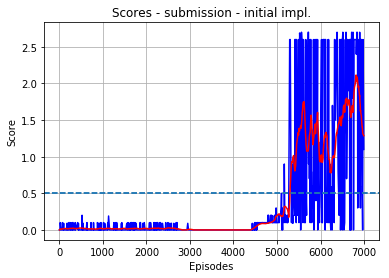

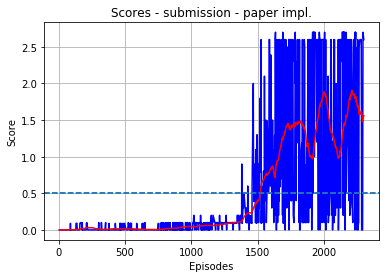

In [53]:
# plotting a single run from the submissions sessions (initial impl.)
plotSingleRun( 'session_submission', title = 'Scores - submission - initial impl.' )
# plotting a single run from the submissions sessions (paper impl.)
plotSingleRun( 'session_submission_original_seed_0', title = 'Scores - submission - paper impl.' )

* Plot some of the results from the initial implementation

    * All initial impl. sessions have the pattern: **session\_submission\_seed\_{seed}**


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9d2a283390>)

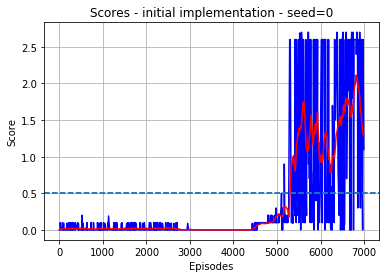

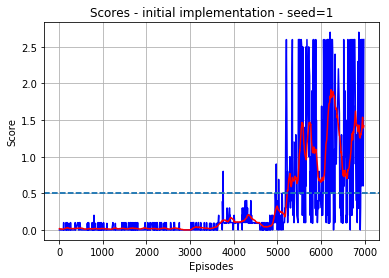

In [12]:
# plotting a single run from the initial impl. sessions (seed=0)
plotSingleRun( 'session_submission_seed_0', title = 'Scores - initial implementation - seed=0' )

# plotting a single run from the initial impl. sessions (seed=1)
plotSingleRun( 'session_submission_seed_1', title = 'Scores - initial implementation - seed=1' )

* Plot some of the results of the original paper impl

    * All original paper impl. sessions have the pattern: **session\_submission\_original\_seed\_{seed}**


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9d29eea358>)

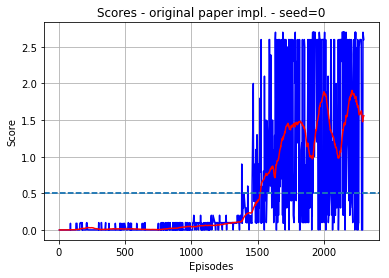

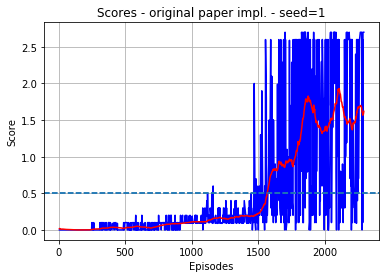

In [52]:
# plotting a single run from the original impl. sessions (seed=0)
plotSingleRun( 'session_submission_original_seed_0', title = 'Scores - original paper impl. - seed=0' )

# plotting a single run from the original impl. sessions (seed=1)
plotSingleRun( 'session_submission_original_seed_1', title = 'Scores - original paper impl. - seed=1' )

* Plotting (running averages) all runs into one graph

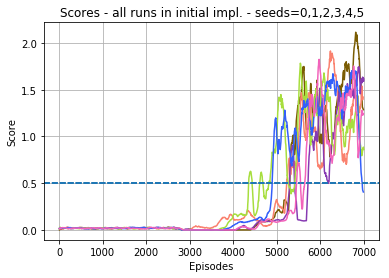

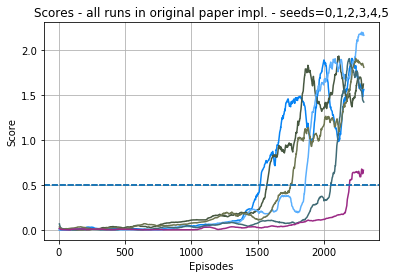

In [55]:
# plotting all runs from the submissions sessions (initial impl.)
fig, axes = None, None
for seed in [0,1,2,3,4,5] :
    fig, axes = plotSingleRun( 'session_submission_seed_' + str(seed), 
                               title = 'Scores - all runs in initial impl. - seeds=0,1,2,3,4,5', 
                               fig = fig, 
                               axes = axes, 
                               hideMain = False,
                               showAll = False,
                               useRandomColor = True )

# plotting a single run from the submissions sessions (original paper impl.)
fig, axes = None, None
for seed in [0,1,2,3,4,5] :
    fig, axes = plotSingleRun( 'session_submission_original_seed_' + str(seed), 
                               title = 'Scores - all runs in original paper impl. - seeds=0,1,2,3,4,5', 
                               fig = fig, 
                               axes = axes, 
                               hideMain = False,
                               showAll = False,
                               useRandomColor = True )

## Plotting various runs using std-plots

We run multiple training **sessions** for the two types of implementations we had. The results in this section will consist on std-plots with regions shaded to represent standard deviation over runs over same implementation, and the mean shown as a single strong lineplot in between.

Recall that the 2 implementations we have are the following:

1. Initial implementation : The starting implementation we had that varied slightly from the original implementation.
2. Original paper implementation : The implementation from before, ammended with a few details from the paper.

* First, let's define a helper functions to load all runs for one configuration. Recall that all experiments have a common base name, given as follows:

**session_submission_[original_]seed_{seed}**, where the string inside '[]' can be replaced by empty strings according to the type of implementation, giving the following generic session names:

    * Initial implementation: session_submission_seed_{seed}
    * Original paper implementation: session_submission_original_seed_{seed}

In [40]:
# same common loader function, as the experiments have ...
# a common naming-structure along experiments
#
# session_submission_[original_]seed_{seed}
#

from itertools import product
from IPython.core.debugger import set_trace

def loadExperimentResults( implementation = [1], seeds = [0,1,2,3,4,5] ) :
    _IMPLEMENTATION_FLAGS = { 1 : '', 2: 'original_' }
    _sessionsResults = { 'scoresAvg' : [],
                         'scoresAll' : [] }
    
    _minLenAll = 10000000
    _minLenAvg = 10000000
    
    for sessImplementationFlag, sessSeed in product( implementation, seeds ) :
        _sessionName = 'session_submission_' + \
                       _IMPLEMENTATION_FLAGS[sessImplementationFlag] + \
                       'seed_' + str(sessSeed)
        
        _resultsFilepathAll = os.path.join( BASE_FOLDER, 'run_' + _sessionName + '_tensorboard_summary_score.csv' )
        _resultsFilepathAvg = os.path.join( BASE_FOLDER, 'run_' + _sessionName + '_tensorboard_summary_avg_score.csv' )
        
        _resultsAll = logger.loadTrainingResultsCsv( _resultsFilepathAll )
        _resultsAvg = logger.loadTrainingResultsCsv( _resultsFilepathAvg )

        _minLenAll = min( len( _resultsAll[1] ), int( _minLenAll ) )
        _minLenAvg = min( len( _resultsAvg[1] ), int( _minLenAvg ) )
        
        _sessionsResults['scoresAvg'].append( _resultsAvg[1] )
        _sessionsResults['scoresAll'].append( _resultsAll[1] )

    # normalize to min-length, as some runs are missing a few data points
    for i in range( len( _sessionsResults['scoresAll'] ) ):
        _sessionsResults['scoresAll'][i] = _sessionsResults['scoresAll'][i][:_minLenAll]
    for i in range( len( _sessionsResults['scoresAvg'] ) ):
        _sessionsResults['scoresAvg'][i] = _sessionsResults['scoresAvg'][i][:_minLenAvg]
        
        
    return _sessionsResults

* Std-plots for the **initial** and **original-paper implementation** runs

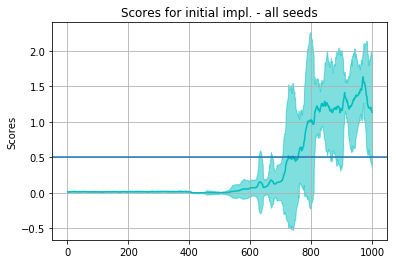

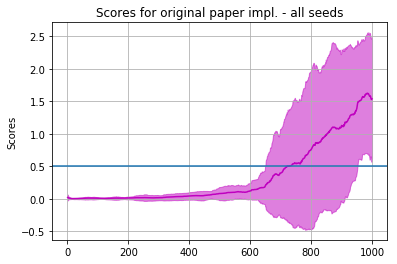

In [56]:
# plotting all runs from the initial implementation sessions
seeds = [0,1,2,3,4,5]
_submissionResults = loadExperimentResults( implementation = [1], seeds = seeds )
axes = plotter.drawStdPlot( _submissionResults['scoresAvg'], 
                            title = 'Scores for initial impl. - all seeds',
                            xlabel = '',
                            ylabel = 'Scores',
                            color = 'c' )

axes.grid( True )
axes.axhline( 0.5 )

# plotting all runs from the original paper implementation sessions
seeds = [0,1,2,3,4,5]
_submissionResults = loadExperimentResults( implementation = [2], seeds = seeds )
axes = plotter.drawStdPlot( _submissionResults['scoresAvg'], 
                            title = 'Scores for original paper impl. - all seeds',
                            xlabel = '',
                            ylabel = 'Scores',
                            color = 'm',
                            axes = None )

axes.grid( True )
axes.axhline( 0.5 )